In [1]:
import torch
from torch import utils,nn,optim

import torchvision as tv
from torchvision import datasets, transforms

import torchmetrics as tm

import lightning.pytorch as pl
from lightning.pytorch import callbacks, tuner

import matplotlib.pyplot as plt

In [25]:
class CelebADataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(CelebADataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([ transforms.Resize((64, 64)),  # Resize images to a specific size
                            transforms.ToTensor()  # Convert images to tensors
                            ])
        
        
    def prepare_data(self):
        datasets.CelebA(root = self.root,split='train',download=True)
        datasets.CelebA(root = self.root,split='test',download=True)

    def setup(self, stage):

        train_dataset = datasets.CelebA(root = self.root,split='train',download=False,transform = self.transform)
        
        # Define the proportions for the split
        train_proportion = 0.8  # 80% for training
        val_proportion = 0.2  # 20% for validation

        # Calculate the sizes of training and validation sets based on the proportions
        train_size = int(train_proportion * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = utils.data.random_split(train_dataset, [train_size, val_size])
        

    def train_dataloader(self):
        return utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        test_dataset =  datasets.CelebA(root = self.root,split='test',download=False,transform = self.transform)
        return utils.data.DataLoader(dataset=test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)



In [26]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VariationalEncoder, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.leakyrelu = nn.LeakyReLU()
        self.linear_mean = nn.Linear(hidden_size, latent_size)
        self.linear_std = nn.Linear(hidden_size, latent_size)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)  # Compute standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mean + eps * std  # Apply reparameterization trick

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.leakyrelu(self.linear(x))
        mu, sigma = self.linear_mean(x), self.linear_std(x)
        z = self.reparameterize(mu, sigma)
        return z, mu, sigma


class VAE(pl.LightningModule):

    def __init__(self, input_size, hidden_size, latent_size, output_size, lr=1e-3):
        super(VAE, self).__init__()

        self.encoder = VariationalEncoder(input_size, hidden_size, latent_size, output_size)
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, input_size), nn.Sigmoid())

        self.learning_rate = lr

    def forward(self, x):
        z, mu, sigma = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu,sigma

    def training_step(self, batch, batch_idx):
        x, _ = batch
        loss, x_hat, y = self._common_step(batch, batch_idx)
        lr = self.optimizers().param_groups[0]['lr']

        self.log_dict({'train_loss': loss, 'learning_rate': lr}, prog_bar=True, on_step=False, on_epoch=True)
        if batch_idx % 100 == 0:
            x = x[:10]
            grid = tv.utils.make_grid(x.view(-1, 1, 28, 28))
            self.logger.experiment.add_image('mnist_images', grid, self.global_step)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, x_hat, y = self._common_step(batch, batch_idx)

        self.log_dict({'val_loss': loss}, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, x_hat, y = self._common_step(batch, batch_idx)

        self.log_dict({'test_loss': loss}, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def _common_step(self, batch, batch_index):
        x, _ = batch
        x = x.flatten(start_dim=1)
        x_hat,mu,sigma = self.forward(x)

        # Compute reconstruction loss
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

        # Compute KL divergence between latent distribution and prior (standard normal)
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

        # Total loss is the sum of reconstruction loss and KL divergence
        loss = recon_loss + kl_div

        return loss, x_hat, x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Define the scheduler
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Metric to monitor for scheduling the learning rate
                'interval': 'epoch',  # Schedule the learning rate every epoch
                'frequency': 1  # Adjust the learning rate at every epoch
            }
        }


In [27]:
# Hyperparametersa
input_size = 28*28
hidden_size = 512
latent_size = 2
output_size = 10
batch = 128
num_epoch = 2
learning_rate = 1e-3

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [28]:
model = VAE(input_size, hidden_size, latent_size, output_size, lr=learning_rate).to(device)

In [29]:


logger = pl.loggers.TensorBoardLogger(save_dir='./tb/mnist', name='Vautoencoder', version=1.2)
profiler = pl.profilers.PyTorchProfiler(
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./dashboard/',),
    schedule=torch.profiler.schedule(skip_first=10, wait=10, warmup=1, active=2)
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="./checkpoints/mnist/Vautoencoder/version_1.2/", monitor="val_loss", mode="min", save_top_k=1)


dm = CelebADataLoader(root='./dataset/', batch_size=batch, num_workers=8)


In [31]:

trainer = pl.Trainer(
    # logger=logger,
    accelerator='auto',
    strategy="auto",
    devices="auto",
    min_epochs=1,
    max_epochs=5,
    precision='16-mixed',
    enable_model_summary=True,
    # profiler=profiler,
    callbacks=[callbacks.EarlyStopping('val_loss'),
               callbacks.StochasticWeightAveraging(swa_lrs=1e-3),
               # checkpoint_callback
              ],
    # enable_checkpointing  = True
    
    
)

ckpt_path=checkpoint_callback.best_model_path


tune = tuner.Tuner(trainer)
# batch_size_tuner = tune.scale_batch_size(model, mode="binsearch", datamodule=dm, init_val=128)
lr_finder = tune.lr_find(model,dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AttributeError: 'LearningRateFinder' object has no attribute 'optimal_lr'

In [ ]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr


In [24]:

if ckpt_path:
    trainer.fit(model, dm,ckpt_path=ckpt_path)  # Model checkpoint
else:
    trainer.fit(model, dm)
    
trainer.validate(model, dm)
trainer.test(model, dm)



  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | VariationalEncoder | 403 K 
1 | decoder | Sequential         | 403 K 
-----------------------------------------------
807 K     Trainable params
0         Non-trainable params
807 K     Total params
3.231     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Swapping scheduler `StepLR` for `SWALR`


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │       33976.703125        │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      32467.41796875       │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 32467.41796875}]

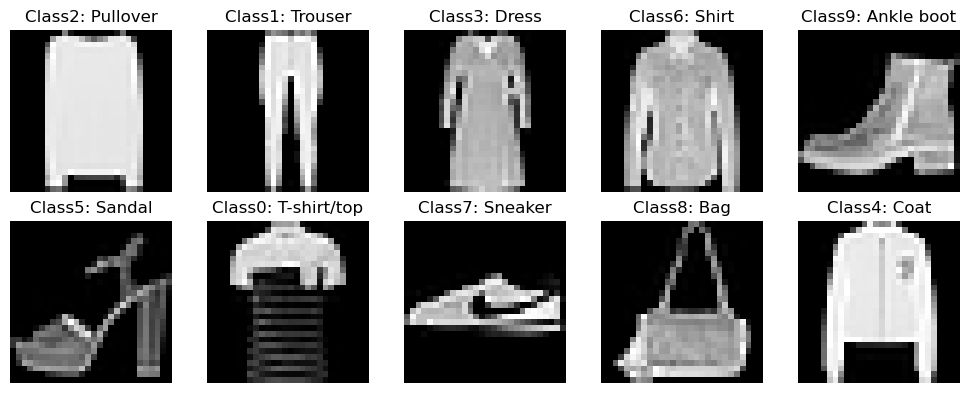

In [43]:
class_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in dm.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class{label}: {class_dict[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # y = [class_dict[_.item()] for _ in y]
        z = autoencoder.encoder(x.flatten(start_dim=1))[0]
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
            
def plot_reconstructed(autoencoder, r0=(-15, 20), r1=(-5, 20), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

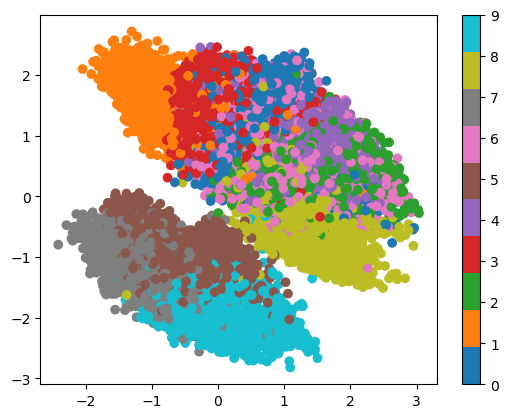

In [41]:
model.eval()
plot_latent(model,dm.train_dataloader())


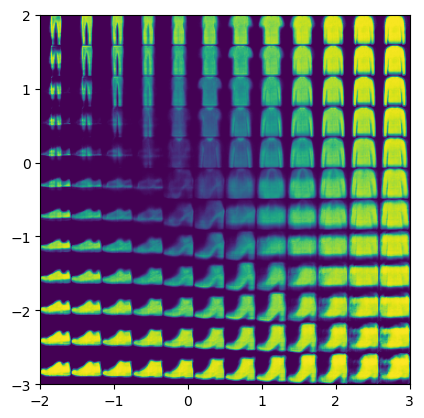

In [34]:
import numpy as np
plot_reconstructed(model,r0=(-2,3),r1=(-3,2))

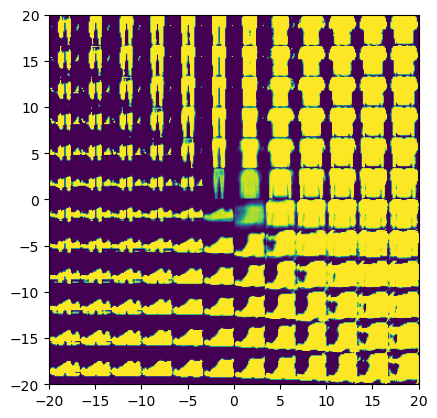

In [33]:
plot_reconstructed(model,r0=(-20,20),r1=(-20,20))

In [55]:
def interpolate(autoencoder, x_1, x_2, n=20):
    z_1 = autoencoder.encoder(x_1)[0]
    z_2 = autoencoder.encoder(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [56]:
for x, y in dm.train_dataloader():
    x_1 = x[y == 1][1]
    x_2 = x[y == 0][1]

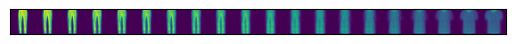

In [57]:
model.eval()
interpolate(model,x_1,x_2)

In [62]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)[0]
    z_2 = autoencoder.encoder(x_2)[0]

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [63]:
interpolate_gif(model, "vae", x_1, x_2)